In [67]:
import pandas as pd
import numpy as np

In [68]:
# read the data
bom = pd.read_csv('bom.csv')
materials = pd.read_csv('materials.csv')
products = pd.read_csv('products.csv')

## Problem 1: Product Cost Analysis

In [69]:
# help fuctions
def production_cost(id_, products, bom, materials):
    '''Get the sum of total production cost'''
    # getting the materials ids
    total_cost = 0
    if id_ in products.id.values:
        ids_of_materials = bom[bom.parent_id == id_].id.values
    else:
        print('not in the list of ids')
        ids_of_materials = None
    # iterate over list of products
    for ids in ids_of_materials:
        total_cost += cost_of_production(ids, materials)
    return total_cost

def cost_of_production(ids_, materials):
    # cost of specific material
    if ids_ in materials.id.values:
         num = materials[materials.id == ids_].cost.values[0] * \
            materials[materials.id == ids_].quantity.values[0]
    else:
        num = 0.000000001 #not to break code
    return num

In [70]:
# calculate 
cost_ = dict()
for ids in products.id.values:
    cost_[ids] = int(production_cost(ids, products, bom, materials))
data = pd.DataFrame(cost_.items(), columns=['id_product', 'total_cost, usd'])

## Result of the 1 task

In [71]:
data.head()

,id_product,"total_cost, usd"
0,1,231
1,20,248
2,21,1003
3,23,2393
4,24,2544


### P.S.  Prefer use Dask instead of Spark for huge computaitons
here the docs
https://docs.dask.org/en/latest/spark.html#reasons-you-might-choose-spark

In [72]:
# here the example
import dask.dataframe as dd
dd.read_csv('materials.csv').head() # dask dataframe

,id,cost,quantity
0,31,104,10
1,53,14,15
2,34,118,1
3,28,108,4
4,27,86,1


## Problem 4: Product Revenue Prediction (Double Exponent)

In [73]:
import pandas as pd
import matplotlib.pyplot as plt 

d = pd.read_csv('revenue_modified.csv', parse_dates=[[1, 2]])

def predict_sales(d, product_id):
    temp = pd.DataFrame(d[d.product_id == \
                          product_id].groupby(['month_year'])['revenue'].sum()).reset_index(drop=False)
    return temp

def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+31): # may 2022 
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), \
                         label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [74]:
temp_20 = predict_sales(d, 20) # predict sales for 20id product

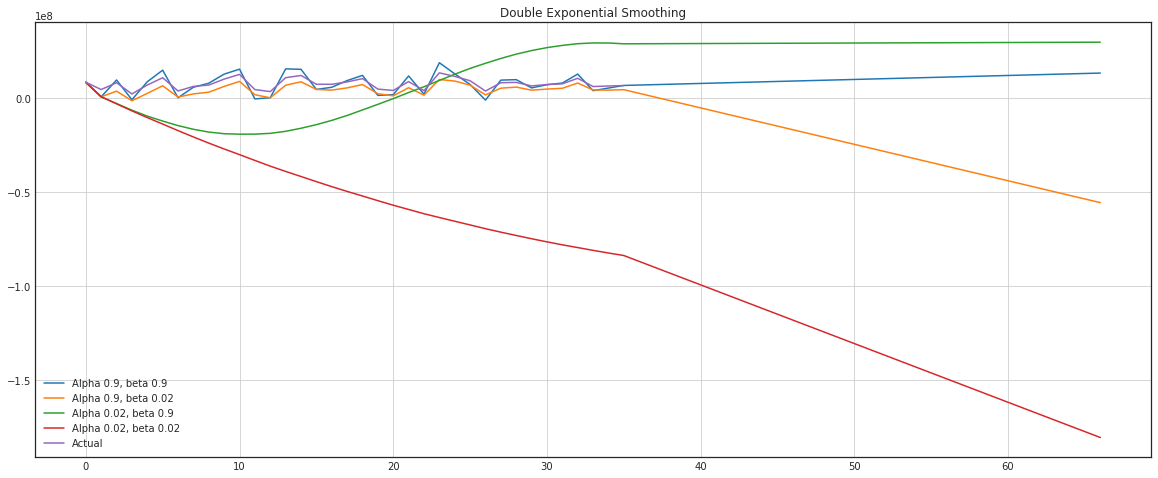

In [75]:
plotDoubleExponentialSmoothing(temp_20.revenue, alphas=[0.9, 0.02], betas=[0.9, 0.02]) # plot to select alphas

In [76]:
pd.DataFrame(double_exponential_smoothing(temp_20.revenue, 0.9, 0.9), columns=['sales'])[65:]

,sales
65,1.318602e+07
66,1.339809e+07


## Here are the sales prediction for april - may 2022

----------------------------------------------------

### Problem 4: Product Revenue Prediction (PySpark) - not completed 

In [77]:
from pyspark import SparkContext
from collections import namedtuple
import gc

sc = SparkContext()

In [78]:
# prepare format, files
sale = namedtuple('records', ['revenue','month','year','id_product'])
temp_ = pd.read_csv('revenue_modified.csv', index_col=False)
temp_.to_csv('temp.csv', header=False)
del temp_
gc.collect()

179973

In [79]:
# check data structure 
sales = sc.textFile('temp.csv')
sales.take(3)

['0,2598592,10,2016,1', '1,6362269,11,2016,1', '2,6140621,12,2016,1']

In [80]:
def parse_records(file):
    fields = file.split(',')
    return sale(*map(int, fields[1:5]))

In [81]:
# parse data
parsed_data = sc.textFile('temp.csv').map(parse_records).cache()

In [82]:
parsed_data.take(4)

[records(revenue=2598592, month=10, year=2016, id_product=1),
 records(revenue=6362269, month=11, year=2016, id_product=1),
 records(revenue=6140621, month=12, year=2016, id_product=1),
 records(revenue=4776972, month=1, year=2016, id_product=1)]

In [84]:
from pyspark import SparkConf
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [85]:
sales = sqlContext.read.format('com.databricks.spark.csv').options(header='true', \
                                            inferschema='true').load('revenue_modified.csv')

In [86]:
sales.take(5)

[Row(revenue=2598592, month=10, year=2016, product_id=1),
 Row(revenue=6362269, month=11, year=2016, product_id=1),
 Row(revenue=6140621, month=12, year=2016, product_id=1),
 Row(revenue=4776972, month=1, year=2016, product_id=1),
 Row(revenue=2046985, month=2, year=2016, product_id=1)]

In [87]:
import pyspark.sql.functions as f

sale_1 = sales.where(f.col("product_id").isin({"20"}))
sale_1.take(5)

[Row(revenue=5036041, month=10, year=2016, product_id=20),
 Row(revenue=4521428, month=11, year=2016, product_id=20),
 Row(revenue=2027930, month=12, year=2016, product_id=20),
 Row(revenue=5310576, month=1, year=2016, product_id=20),
 Row(revenue=1245396, month=2, year=2016, product_id=20)]

In [88]:
sales.cache()
sales.printSchema()

root
 |-- revenue: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_id: integer (nullable = true)



In [89]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['month', 'year'], \
                                  outputCol = 'features')

sale_1_df = vectorAssembler.transform(sale_1)

sale_1_df = sale_1_df.select(['features', 'revenue'])

sale_1_df.show(3)

+-------------+-------+
|     features|revenue|
+-------------+-------+
|[10.0,2016.0]|5036041|
|[11.0,2016.0]|4521428|
|[12.0,2016.0]|2027930|
+-------------+-------+
only showing top 3 rows



In [90]:
splits = sale_1_df.randomSplit([0.8, 0.2])

train_df = splits[0]
test_df = splits[1]

In [91]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='revenue', \
                      maxIter=10, regParam=0.1, elasticNetParam=0.9)

lr_model = lr.fit(train_df)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [91291.91911496139,-3521.5728100347005]
Intercept: 10230629.335353438
